## Attention linking PoC

### Hyphotesis:

Transformers' attention reflects the internal relations of entities in the text and hence does reflect the importance of the pieces of text.

### Experiment Methodology:

We aggregate the selected attention heads' weights $W$ of all keys (=input wordpiece) for all values (=output wordpieces). We observe, whether, and how much the aggregated weights for "keyphrases" outweight the other parts of text.

We experiments with various methods of attention heads' aggregation:

1. aggregate all heads in given layer. It was shown that lower-level layers really reflect the morphology and higher reflect semantical properties, so coreferencing is a good candidate for higher-level layers.

2. aggregate multiple layers after aggregation 1. 

3. do not aggregate and use the head in standalone

Additionally, we might want to try nonlinear token classification of keywords, based on each layer. This can be then done also on the Transformer output.

### Evaluation

We measure the contrast of weights to keyphrases, compared to other pieces of text. We quantify the contrast by the mean value per-wordpiece and by distribution, visually, and by descriptive statistics.

### Output:

We pick the methodology, that gives the highest aggregated contrast of weights to keyphrases, compared to other pieces of text. This will be used in Information Retrieval system to weight the SCU present in the text.

### Keyphrases load

In [1]:
# KPCrowd contains a folder with keyphrases in keys/{k}.key and texts in docsutf8/{k}.txt
import os
basepath = "data/KPCrowd_v1.1"

ktexts = {}

for kpath in os.listdir(os.path.join(basepath, "keys")):
    keys = open(os.path.join(basepath, "keys", kpath), "r").readlines()
    text = open(os.path.join(basepath, "docsutf8", os.path.basename(kpath).split(".")[0] + ".txt"), "r").read()
    ktexts[os.path.basename(kpath).split(".")[0]] = {"keywords": [k.strip() for k in keys], "text": text}

In [2]:
ktexts.__len__()

500

### Attention inference with pretrained models

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
!pip install transformers

In [4]:
from bertviz import neuron_view
from transformers import BertTokenizer, BertModel

In [5]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [6]:
from bertviz import head_view
from transformers import GPT2Tokenizer, GPT2Model

In [192]:
# version: BERT
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

sentence_a = "This morning, the president announced it."
# sentence_b = "The cat lay on the rug"
sentence_b = sentence_a

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [155]:
# version: GPT-2
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
# NOTE: this updates the visualization above
head_view(attention, tokens)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Ratio of keyphrases-to-no-keyphrases 

In [9]:
import torch

In [10]:
# text = "This keyed text contains some key words with many keywords."
# keywds = ["key words", "keyed", "."]
# model = "bert"
def get_text_links(text: str, keywds: list, model: str):
#     print(keywds)
#     print(text)
    if model == "bert":
        model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    elif model == "gpt":
        model = GPT2Model.from_pretrained("gpt2", output_attentions=True)
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    # overflow handling: to process everything, replace [text] with native text splitting 
    # we do not know, how to losslessly handle overflowing sentences! We need longer attention here
    # inputs = tokenizer.batch_encode_plus([text], return_tensors='pt', add_special_tokens=True, max_length=512, pad_to_max_length=True)
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True, max_length=512)
    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']
    attention = model(input_ids, token_type_ids=token_type_ids)[-1]
    # create keywords' wordpieces mask: for each keyphrase, find all word positions, where it resides
    wpieces = tokenizer.convert_ids_to_tokens(input_ids.view(-1))
    keywd_masks = []
    for keywd in keywds:
        keywd_wpieces = tokenizer.tokenize(keywd, add_special_tokens=True)
        keywd_masks.append([wpieces[i:i+len(keywd_wpieces)] == keywd_wpieces for i, _ in enumerate(wpieces)])
    keywd_mask_t = torch.sum(torch.stack([torch.tensor(mask) for mask in keywd_masks], axis=1), axis=1)
    if torch.sum(keywd_mask_t) == 0:
        print("No keywords in max_length window")
        return None, None
    # collect attention values, for keywd_links and nokeywd_links
    keywd_in_links = {i: {} for i, _ in enumerate(attention)}
    nokeywd_in_links = {i: {} for i, _ in enumerate(attention)}
    for layer_i, att_i in enumerate(attention):
        for head_i, head_att in enumerate(att_i[0]):
            keywd_in_links[layer_i][head_i] = torch.sum(head_att * keywd_mask_t).item() / torch.sum(keywd_mask_t).item()
            nokeywd_in_links[layer_i][head_i] = torch.sum(head_att * (~keywd_mask_t)).item() / torch.sum(~keywd_mask_t).item()

    return keywd_in_links, nokeywd_in_links

In [11]:
# generate matrix M of dims ({model}, {no_texts}, {is_kw}, {layer}, {head})
import numpy as np
from tqdm import tqdm

links = []
for m_i, model in enumerate(['bert', 'gpt']):
    links.append([])
    for kw_i, ktext in tqdm(enumerate(tuple(ktexts.values())[:50]), desc=model):
        links[m_i].append([])
        kw_links, nokw_links = get_text_links(ktext['text'], ktext['keywords'], model)
        if kw_links is None:
            # no kwlinks in max_seq_len window -> omit from stats
            links[m_i][kw_i] = np.full(np.array(links[0][0]).shape, -1).tolist()
            continue
        for attentions in (kw_links, nokw_links):
            # add attentions consequently, of keyword and nokeyword words, and of all layers and heads
            links[m_i][kw_i].append([[head for head in layer.values()] for layer in attentions.values()])

bert: 50it [08:06,  9.73s/it]
gpt: 3it [00:27,  9.92s/it]

No keywords in max_length window


gpt: 8it [01:13,  9.53s/it]

No keywords in max_length window


gpt: 16it [02:41, 10.66s/it]

No keywords in max_length window


gpt: 24it [03:40,  7.12s/it]

No keywords in max_length window


gpt: 32it [04:39,  7.02s/it]

No keywords in max_length window


gpt: 41it [06:21, 11.21s/it]

No keywords in max_length window


gpt: 45it [07:04, 10.72s/it]

No keywords in max_length window


gpt: 48it [07:27,  8.52s/it]

No keywords in max_length window


gpt: 50it [07:44,  9.28s/it]


In [13]:
links_m = np.array(links)

In [15]:
links_m_samples = []
for m_i, model in enumerate(['bert', 'gpt']):
    l_m = links_m[m_i]
    for kw_i, ktext in tqdm(enumerate(tuple(ktexts.values())[:50]), desc=model):
        l_kw = l_m[kw_i]
        for a_i, attentions in enumerate((kw_links, nokw_links)):
            links_m_samples.extend([{"model": model, "kname_i": kw_i, "is_kw": a_i == 0, 
                                     "layer": l_i, "head": h_i, "attention": l_kw[a_i][l_i][h_i]} 
                                    for l_i in range(len(l_kw[a_i])) 
                                    for h_i in range(len(l_kw[a_i][l_i]))])

bert: 50it [00:00, 1659.68it/s]
gpt: 50it [00:00, 2085.20it/s]


In [114]:
import pandas as pd
links_m_df = pd.DataFrame(links_m_samples)
links_m_df = links_m_df[links_m_df.attention != -1]

In [115]:
# Relative attention = (mean attention value of key wordpieces) - (of the other wordpieces)

rel_attentions = links_m_df.groupby(by=["model", "layer", "head", "kname_i"])["attention"].agg(list).apply(lambda x: x[0] - x[1])
rel_attentions = rel_attentions.reset_index()
# only rename attention to rel_attention
rel_attentions.columns = rel_attentions.columns[:-1].tolist() + ["rel_attention"]

In [116]:
links_m_df = pd.merge(links_m_df, rel_attentions, on=["model", "layer", "head", "kname_i"], how='left')

In [117]:
links_m_df

,model,kname_i,is_kw,layer,head,attention,rel_attention
0,bert,0,True,0,0,1.190809,0.144342
1,bert,0,True,0,1,1.607763,0.459759
2,bert,0,True,0,2,0.639232,-0.272912
3,bert,0,True,0,3,1.073234,0.055400
4,bert,0,True,0,4,1.143806,0.108786
...,...,...,...,...,...,...,...
26491,gpt,49,False,11,7,0.996453,-0.908026
26492,gpt,49,False,11,8,0.998643,-0.347400
26493,gpt,49,False,11,9,0.996664,-0.854018
26494,gpt,49,False,11,10,0.997222,-0.711034


/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


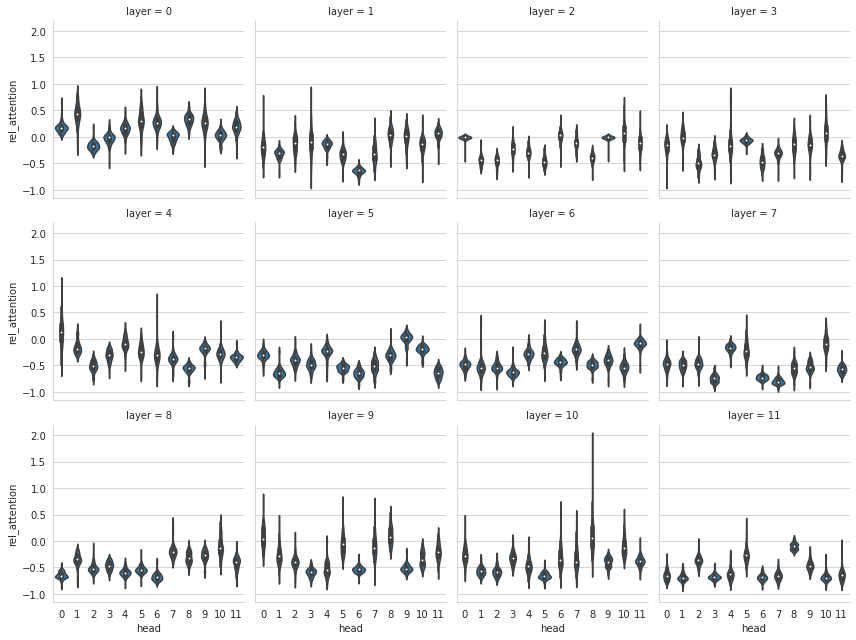

In [189]:
# BERT distributions of attentions for each head
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "bert")]

# plot
sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True, hue="model")
g.map(sns.violinplot, "head", "rel_attention")
# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
# sns.despine()

<AxesSubplot:xlabel='layer', ylabel='head'>

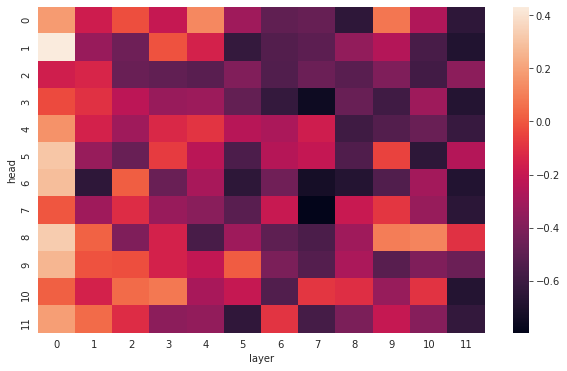

In [190]:
# mean relative attentions (mean_key_attention - mean_NOkey_attention) for each head 
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)

In [168]:
# for visualization, we cut-off the relative attentions bigger than 10
len(links_m_df[(links_m_df.rel_attention < 10)]), len(links_m_df[(links_m_df.rel_attention >= 10)])

(20718, 5778)

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


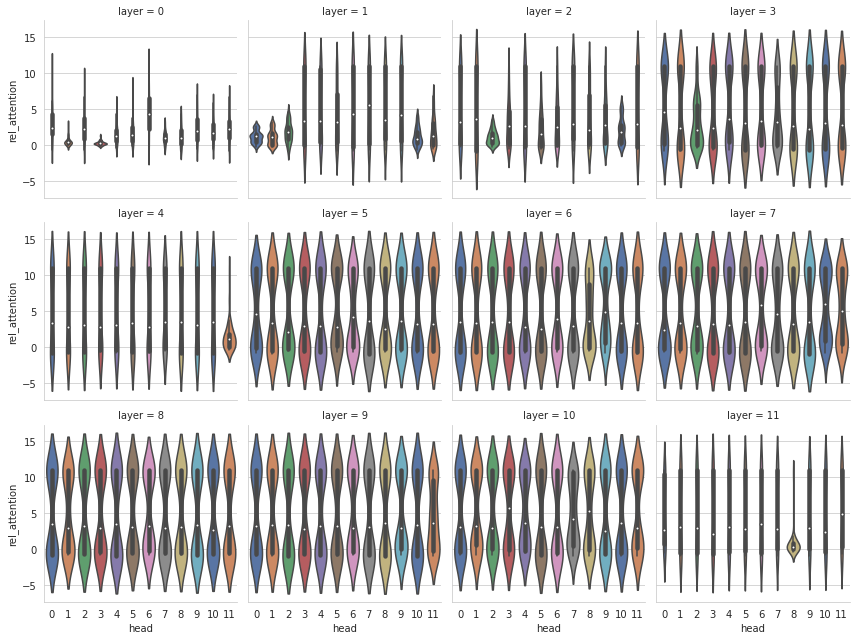

In [253]:
# # mean relative attentions (mean_key_attention - mean_NOkey_attention) for each head: attentions larger than 10 are round down to 11
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]
outliers = links_plot_subset.attention > 10
links_plot_subset.loc[outliers, "rel_attention"] = 11
links_plot_subset = links_plot_subset[links_plot_subset.rel_attention <= 11]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
fgrid = g.map(sns.violinplot, "head", "rel_attention", palette="deep")
# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


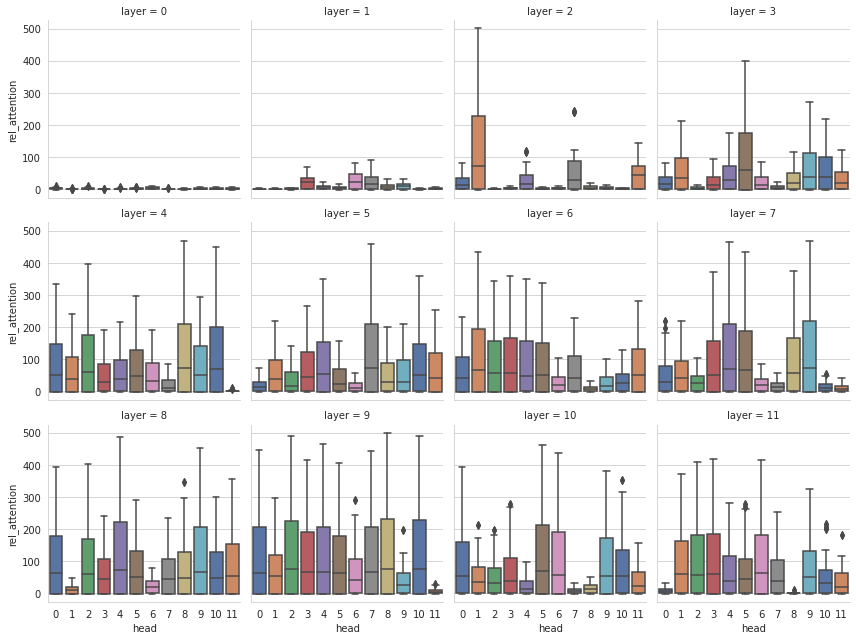

In [252]:
# mean relative attentions: no filtering

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
fgrid = g.map(sns.boxplot, "head", "rel_attention", palette="deep")
# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


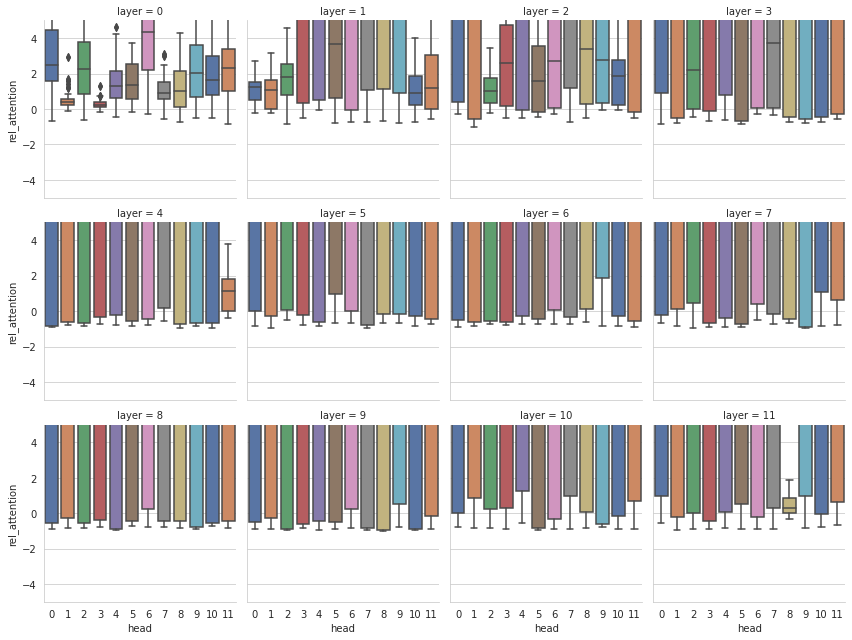

In [251]:
# mean relative attentions: no filtering, Zoom, to zero (=same attentions for key and NOkey parts)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
fgrid = g.map(sns.boxplot, "head", "rel_attention", palette="deep")
plt.ylim(-5, 5)

# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


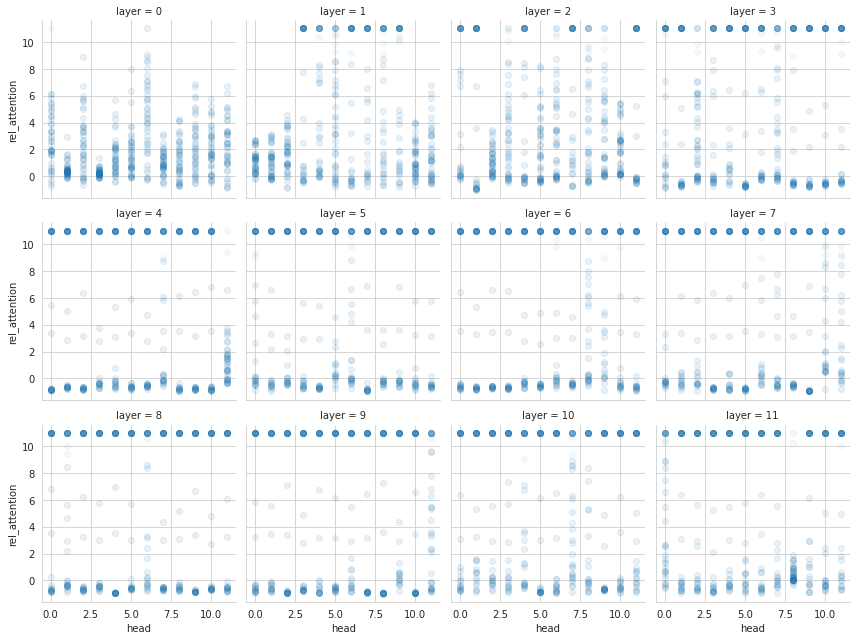

In [255]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]
outliers = links_plot_subset.attention > 10
links_plot_subset.loc[outliers, "rel_attention"] = 11
links_plot_subset = links_plot_subset[links_plot_subset.rel_attention <= 11]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
# fgrid = g.map(sns.violinplot, "head", "rel_attention")
g.map(plt.scatter, "head", "rel_attention", alpha=0.05)
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

<AxesSubplot:xlabel='layer', ylabel='head'>

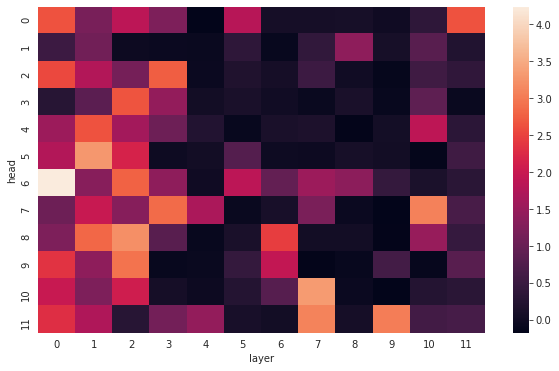

In [258]:
links_plot_subset = links_m_df[(links_m_df.rel_attention < 10) & (links_m_df.model == "gpt")]
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)

<AxesSubplot:xlabel='layer', ylabel='head'>

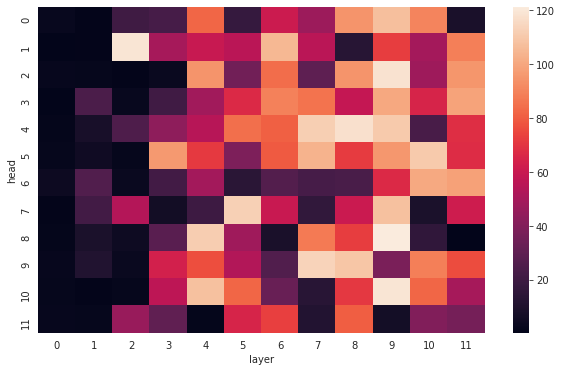

In [191]:
# we see that extremes filtering here makes a huge difference
links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "gpt")]
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:xlabel='layer', ylabel='head'>

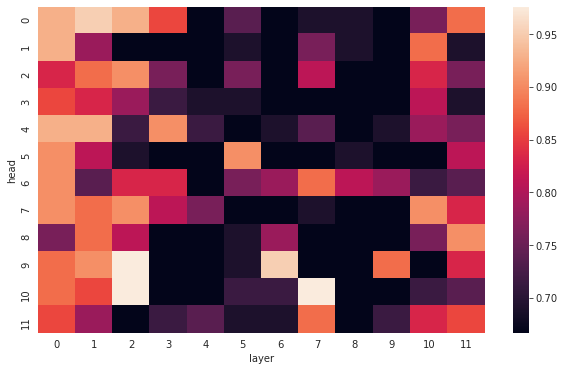

In [250]:
# for each head, how much % of relative attentions is higher than 0
links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "gpt")]
links_plot_subset.rel_attention = links_plot_subset.rel_attention.apply(lambda val: 1 if val > 0 else 0)
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)